# High Times or Drug Crimes?
### Assessing the risk of drug addiction 

In this notebook, we will be working with a dataset on personality traits and drug usage. Our aim is to build a tool that can determine wether **someone who got caught using an illegal substance for the first time is at risk of developing a drug addiction**. Since we consider it a possibility that people sometimes really just want to try new things, it would be important for any kind of social authority (be it parents, teachers or social workers) to assess wether further (and maybe more drastic) prevention measures should be undertaken - and thus could be allocated more efficiently in general.

We work with the results of an online survey, which had been conducted in 2011 and 2012 and offers information on more than 1800 respondents concerning socio-cultural background, personality traits (the big five inventory + two more) and usage of 18 legal and illegal substances (https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29
). Since the data has been cleaned, partially quantified and standardized already, the following data cleansing and conventional feature engineering parts will be very small, albeit we will be engaged in label engineering in some way, when we define different clusters (illegal substance addiction in general, a stoner, a party and a junkie-drug cluster) as our targets. Because we always have more non-users than users in the more specific clusters, we will use synthetic minority oversampling for these clusters. 

Later on, we will **train mutliple classification algorithms** (standard and ensemble methods), do some hyperparameter tuning towards better recall scores (we can definitely sacrifice a bit of precsion in our case) and test them as well. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

from pandas.plotting import scatter_matrix
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)

from plotly.subplots import make_subplots


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
drugs = pd.read_excel('drug_consumption.xls')

In [3]:
drugs.shape


(1885, 32)

In [4]:
drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
ID           1885 non-null int64
Age          1885 non-null float64
Gender       1885 non-null float64
Education    1885 non-null float64
Country      1885 non-null float64
Ethnicity    1885 non-null float64
Nscore       1885 non-null float64
Escore       1885 non-null float64
Oscore       1885 non-null float64
Ascore       1885 non-null float64
Cscore       1885 non-null float64
Impulsive    1885 non-null float64
SS           1885 non-null float64
Alcohol      1885 non-null object
Amphet       1885 non-null object
Amyl         1885 non-null object
Benzos       1885 non-null object
Caff         1885 non-null object
Cannabis     1885 non-null object
Choc         1885 non-null object
Coke         1885 non-null object
Crack        1885 non-null object
Ecstasy      1885 non-null object
Heroin       1885 non-null object
Ketamine     1885 non-null object
Legalh       1885 non-null objec

In [5]:
drugs.head()

ID      Age   Gender  Education  Country  Ethnicity   Nscore   Escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4   5  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   

    Oscore   Ascore   Cscore  Impulsive       SS Alcohol Amphet Amyl Benzos  \
0 -0.58331 -0.91699 -0.00665   -0.21712 -1.18084     CL5    CL2  CL0    CL2   
1  1.43533  0.76096 -0.14277   -0.71126 -0.21575     CL5    CL2  CL2    CL0   
2 -0.84732 -1.62090 -1.01450   -1.37983  0.40148     CL6    CL0  CL0    CL0   
3 -0.01928  0.59042  0.58489   -1.37983 -1.18084     CL4    CL0  CL0    CL3   
4 -0.45174 -0.30172  1.30612   -0.21712 -0.21575     CL4    CL1  CL1    CL0   

  Caff Cannabis Choc Coke Crack Ecstasy Heroin Ketamine Legalh  LSD Meth  \
0  CL6      CL0  CL5  CL0   CL0     CL0    CL0      CL0    CL0  CL0  CL0   
1  CL6      CL4  CL6  CL3   CL0     CL4    CL0      CL2    CL0  CL2  CL3   
2  CL6      CL3  CL4  CL0   CL0     CL0    CL0      CL0    CL0  CL0  CL0   
3  CL5      CL2  CL4  CL2   CL0     CL0    CL0      CL2    CL0  CL0  CL0   
4  CL6      CL3  CL6  CL0   CL0     CL1    CL0      CL0    CL1  CL0  CL0   

  Shrooms Nicotine Semer  VSA  
0     CL0      CL2   CL0  CL0  
1     CL0      CL4   CL0  CL0  
2     CL1      CL0   CL0  CL0  
3     CL0      CL2   CL0  CL0  
4     CL2      CL2   CL0  CL0

In [6]:
drugs.describe()

ID         Age       Gender    Education      Country  \
count  1885.000000  1885.00000  1885.000000  1885.000000  1885.000000   
mean    945.294960     0.03461    -0.000256    -0.003806     0.355542   
std     545.167641     0.87836     0.482588     0.950078     0.700335   
min       1.000000    -0.95197    -0.482460    -2.435910    -0.570090   
25%     474.000000    -0.95197    -0.482460    -0.611130    -0.570090   
50%     946.000000    -0.07854    -0.482460    -0.059210     0.960820   
75%    1417.000000     0.49788     0.482460     0.454680     0.960820   
max    1888.000000     2.59171     0.482460     1.984370     0.960820   

         Ethnicity       Nscore       Escore       Oscore       Ascore  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean     -0.309577     0.000047    -0.000163    -0.000534    -0.000245   
std       0.166226     0.998106     0.997448     0.996229     0.997440   
min      -1.107020    -3.464360    -3.273930    -3.273930    -3.464360   
25%      -0.316850    -0.678250    -0.695090    -0.717270    -0.606330   
50%      -0.316850     0.042570     0.003320    -0.019280    -0.017290   
75%      -0.316850     0.629670     0.637790     0.723300     0.760960   
max       1.907250     3.273930     3.273930     2.901610     3.464360   

            Cscore    Impulsive           SS  
count  1885.000000  1885.000000  1885.000000  
mean     -0.000386     0.007216    -0.003292  
std       0.997523     0.954435     0.963701  
min      -3.464360    -2.555240    -2.078480  
25%      -0.652530    -0.711260    -0.525930  
50%      -0.006650    -0.217120     0.079870  
75%       0.584890     0.529750     0.765400  
max       3.464360     2.901610     1.921730

In [7]:
drugs.columns = drugs.columns.str.lower()

drugs.drop(labels='id', inplace=True, axis=1)

drugs.drop(drugs[drugs['semer'] != 'CL0'].index, inplace = True)



In [8]:
drugs.drop(labels='semer', inplace=True, axis=1)

Okay, let's make a seperate dataframe for visualization purposes:

In [9]:
drugs_vis = drugs.copy()

In [10]:
drugs_vis = drugs_vis.replace(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],[0,1,2,3,4,5,6])

In [11]:
drugs_vis.gender = drugs_vis.gender.replace([0.48246, -0.48246 ],['female', 'male' ])

drugs_vis.age = drugs_vis.age.replace([-0.95197, -0.07854, 0.49788, 1.09449, 1.82213, 2.59171 ],
                              ['18-24', '25-34', '35-44', '45-54', '55-64', '65+' ])

drugs_vis.education = drugs_vis.education.replace([-2.43591, -1.73790, -1.43719, -1.22751, -0.61113, -0.05921, 0.45468, 1.16365, 1.98437 ],
                              ['under_16', 'with_16', 'with_17', 'with_18', 'college_without_degree', 'prof_certificaqte', 'univ_degree',  
                              'masters', 'doctorate'])

drugs_vis.country = drugs_vis.country.replace([-0.09765, 0.24923, -0.46841, -0.28519, 0.21128, 0.96082,-0.57009 ],
                              ['Australia', 'Canada', 'New Zealand', 'Other', 'Republic of Ireland', 'UK', 'USA'])


drugs_vis.ethnicity = drugs_vis.ethnicity.replace([-0.50212,-1.10702, 1.90725, 0.12600, -0.22166, 0.11440,-0.31685],
                              ['Asian', 'Black', 'Mixed-Black/Asian', 'Mixed-White/Asian', 'Mixed-White/Black', 'Other', 'White'])


Let's look at a couple of distributions:

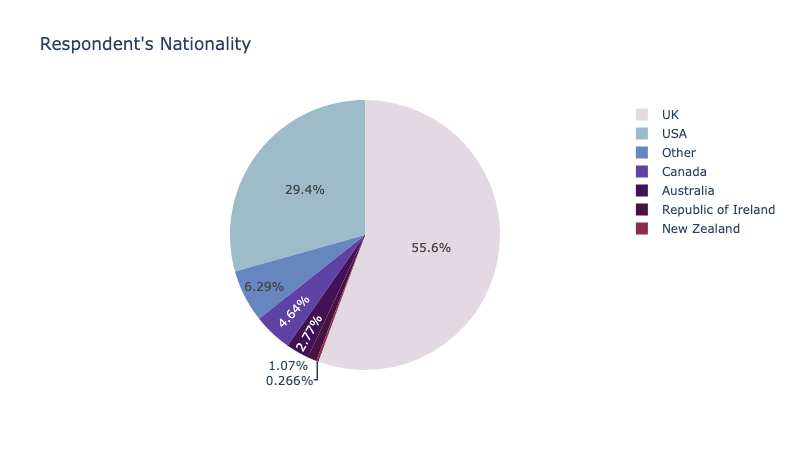

In [12]:
pie_nation = px.pie(drugs_vis, names='country' ,title= 'Respondent\'s Nationality', color_discrete_sequence=px.colors.cyclical.Twilight)
pie_nation.show()

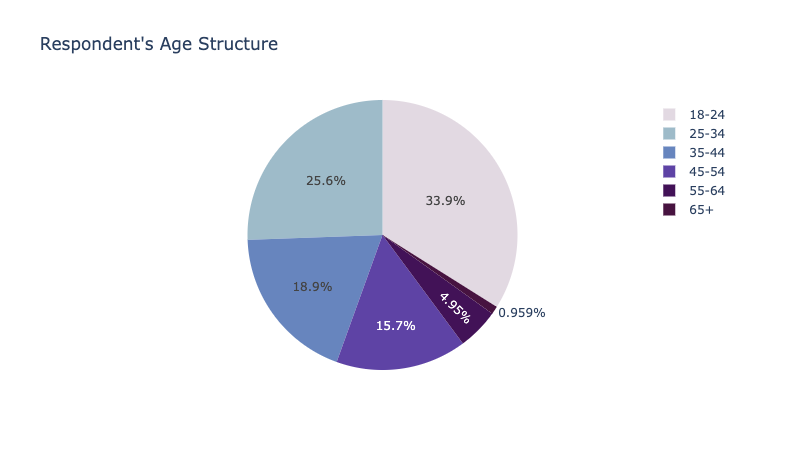

In [13]:
pie_age = px.pie(drugs_vis, names='age' ,title= 'Respondent\'s Age Structure', color_discrete_sequence=px.colors.cyclical.Twilight)

pie_age.show()

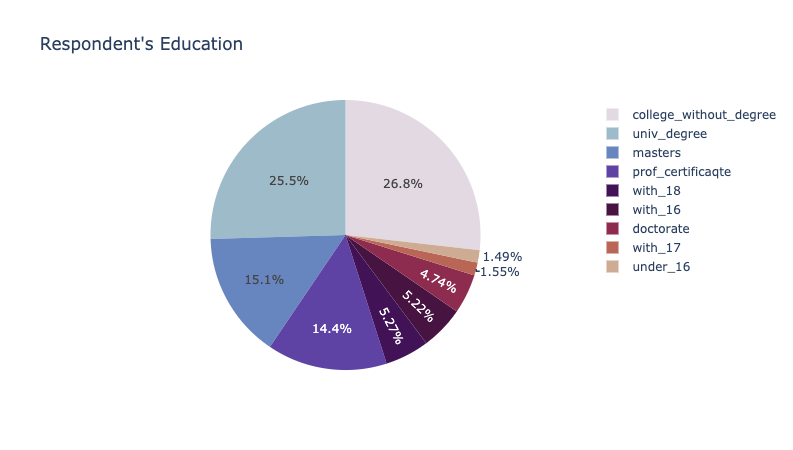

In [14]:
pie_age = px.pie(drugs_vis, names='education' ,title= 'Respondent\'s Education', color_discrete_sequence=px.colors.cyclical.Twilight)
pie_age.show()

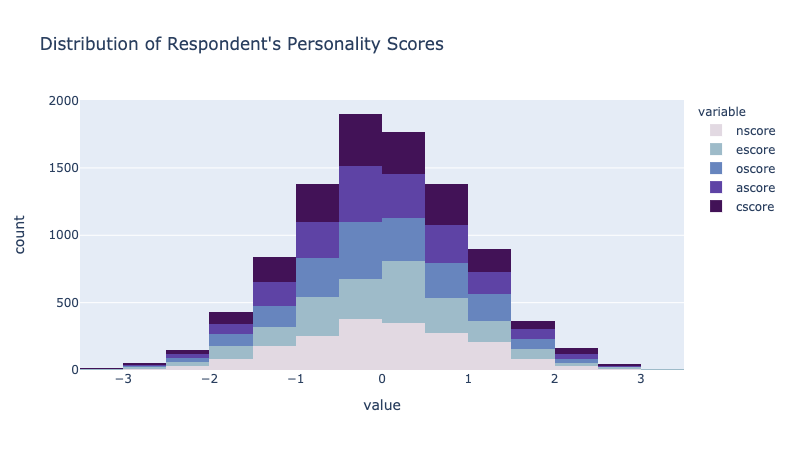

In [15]:
hist_personal = px.histogram(drugs_vis, x= ['nscore', 'escore', 'oscore', 'ascore', 'cscore'],title= 'Distribution of Respondent\'s Personality Scores', nbins = 15, color_discrete_sequence=px.colors.cyclical.Twilight)
hist_personal.show()

The standardized personality scores are pretty much normally distributed, which means that - with respect to personality types - our sample should be representative.


Now, let's look how certain personality traits differ by drug usage/frequency. Assuming that there is a good variation in consumption of those substances, we want to compare the n,c and ss score with chocolate, heroin and cannabis each:

In [16]:
choc_mean_n = drugs_vis.groupby('choc').nscore.mean()
choc_mean_ss = drugs_vis.groupby('choc').ss.mean()
choc_mean_c = drugs_vis.groupby('choc').cscore.mean()

heroin_mean_n = drugs_vis.groupby('heroin').nscore.mean()
heroin_mean_ss = drugs_vis.groupby('heroin').ss.mean()
heroin_mean_c = drugs_vis.groupby('heroin').cscore.mean()

can_mean_n = drugs_vis.groupby('cannabis').nscore.mean()
can_mean_ss = drugs_vis.groupby('cannabis').ss.mean()
can_mean_c = drugs_vis.groupby('cannabis').cscore.mean()

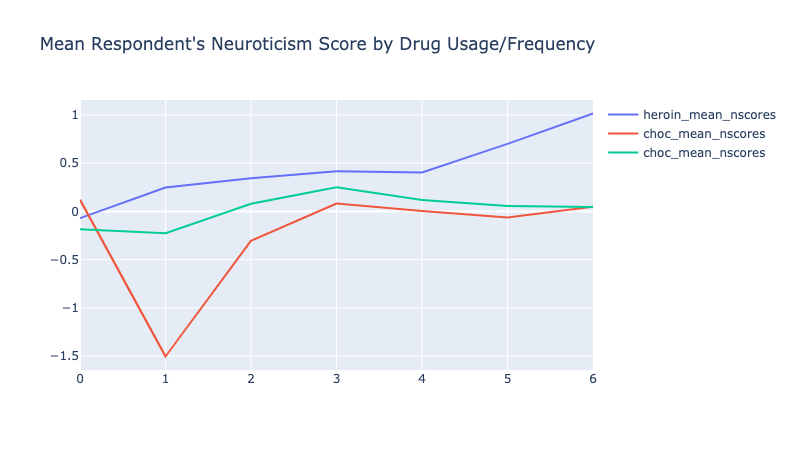

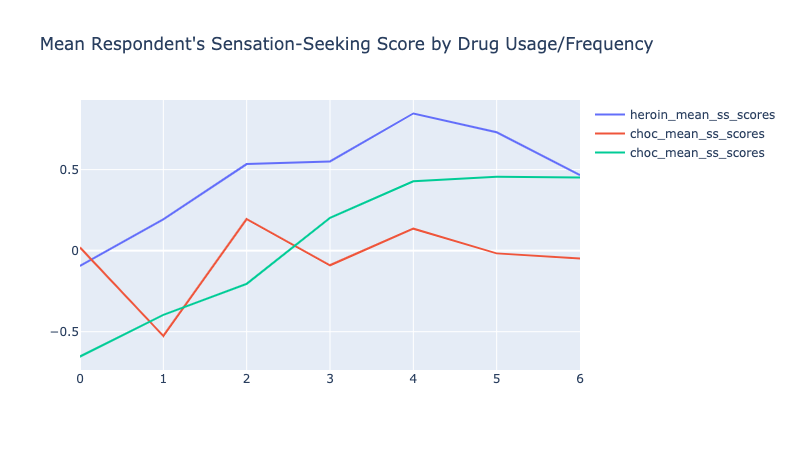

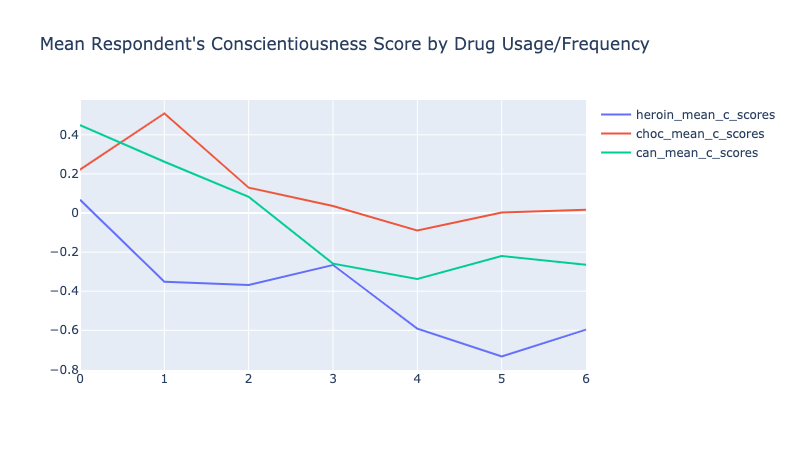

In [17]:
fig_nscores = go.Figure()

fig_nscores.add_trace(go.Scatter(y=heroin_mean_n,
                    mode='lines',
                    name='heroin_mean_nscores'))
fig_nscores.add_trace(go.Scatter(y=choc_mean_n,
                    mode='lines',
                    name='choc_mean_nscores'))

fig_nscores.add_trace(go.Scatter(y=can_mean_n,
                    mode='lines',
                    name='choc_mean_nscores'))

fig_nscores.update_layout(
    title="Mean Respondent\'s Neuroticism Score by Drug Usage/Frequency "
    
    
    )

fig_sscores = go.Figure()
fig_sscores.add_trace(go.Scatter(y=heroin_mean_ss,
                    mode='lines',
                    name='heroin_mean_ss_scores'))
fig_sscores.add_trace(go.Scatter(y=choc_mean_ss,
                    mode='lines',
                    name='choc_mean_ss_scores'))

fig_sscores.add_trace(go.Scatter(y=can_mean_ss,
                    mode='lines',
                    name='choc_mean_ss_scores'))

fig_sscores.update_layout(
    title="Mean Respondent\'s Sensation-Seeking Score by Drug Usage/Frequency "
    
    )



fig_c_cores = go.Figure()
fig_c_cores.add_trace(go.Scatter(y=heroin_mean_c,
                    mode='lines',
                    name='heroin_mean_c_scores'))
fig_c_cores.add_trace(go.Scatter(y=choc_mean_c,
                    mode='lines',
                    name='choc_mean_c_scores'))

fig_c_cores.add_trace(go.Scatter(y=can_mean_c,
                    mode='lines',
                    name='can_mean_c_scores'))

fig_c_cores.update_layout(
    title="Mean Respondent\'s Conscientiousness Score by Drug Usage/Frequency "
    )
    
    

fig_nscores.show()    
fig_sscores.show()
fig_c_cores.show()    

Wow, we see that there's quite a bit going on if we contrast personality traits with specific drug usages (of course, chocolate only serves as a baseline here (; )

Let's see how those different drug usages(and chocolate consumption) look when we check for different education levels and also compare female to males:

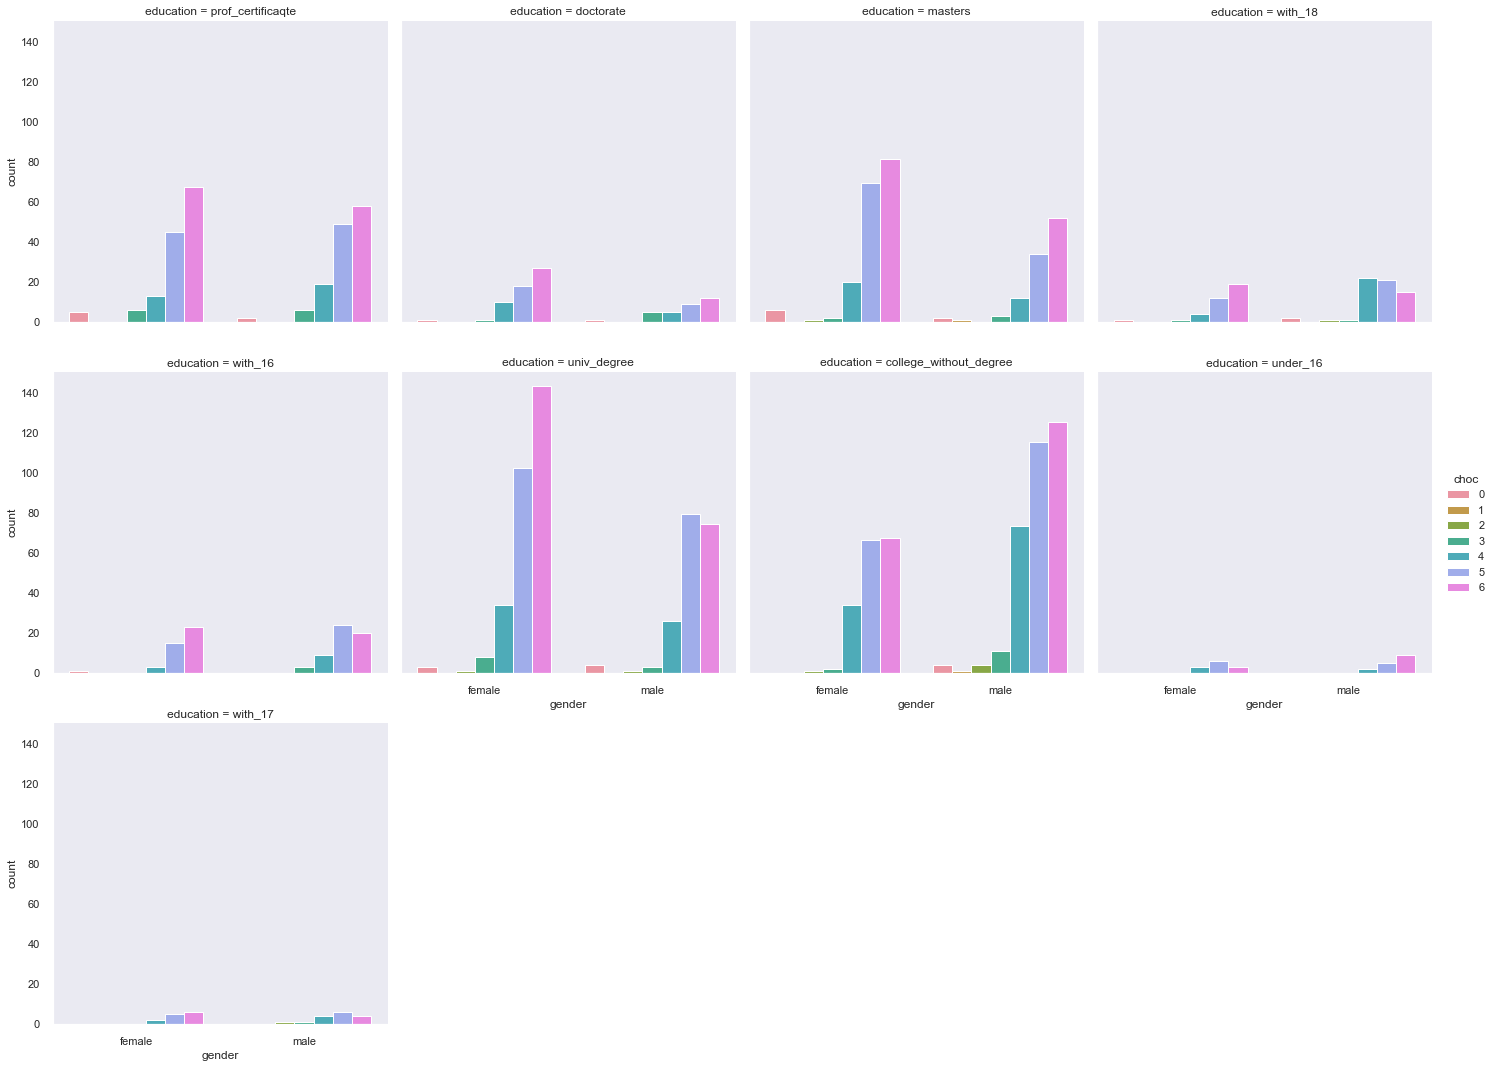

In [18]:
sns.set(style="dark", palette='viridis',)
sns.catplot("gender", col='education', data=drugs_vis, hue='choc', kind="count", col_wrap=4, );

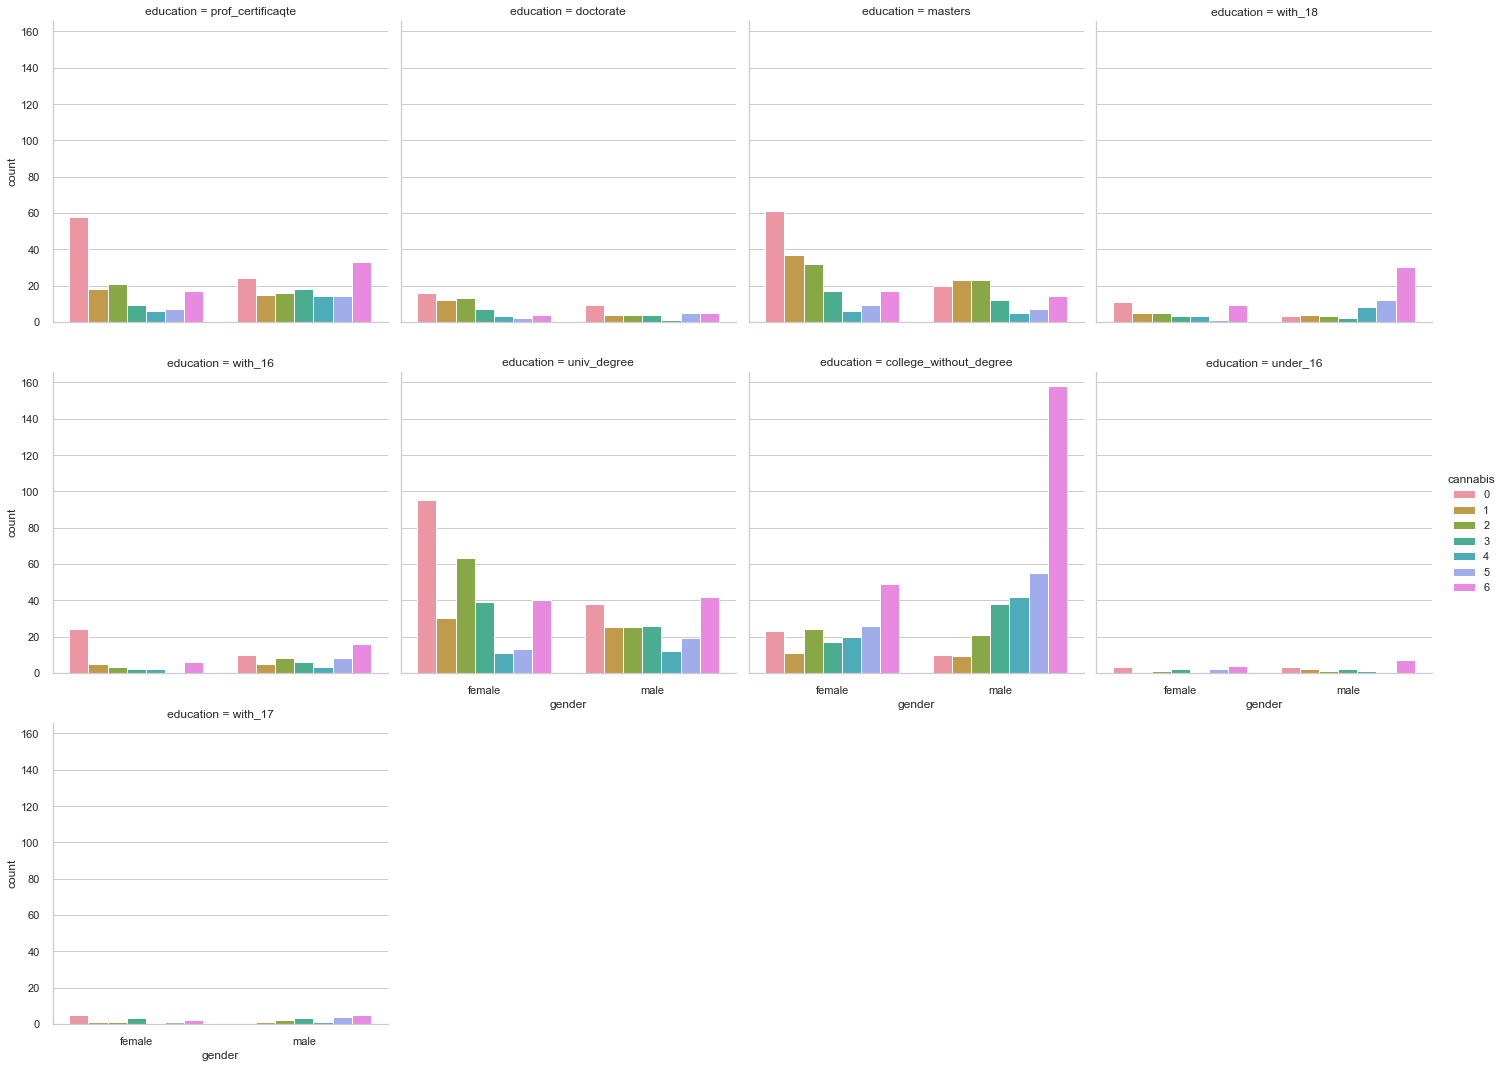

In [19]:
sns.set(style="whitegrid", palette='viridis')
sns.catplot("gender", col='education', data=drugs_vis, hue='cannabis', kind="count", col_wrap=4);

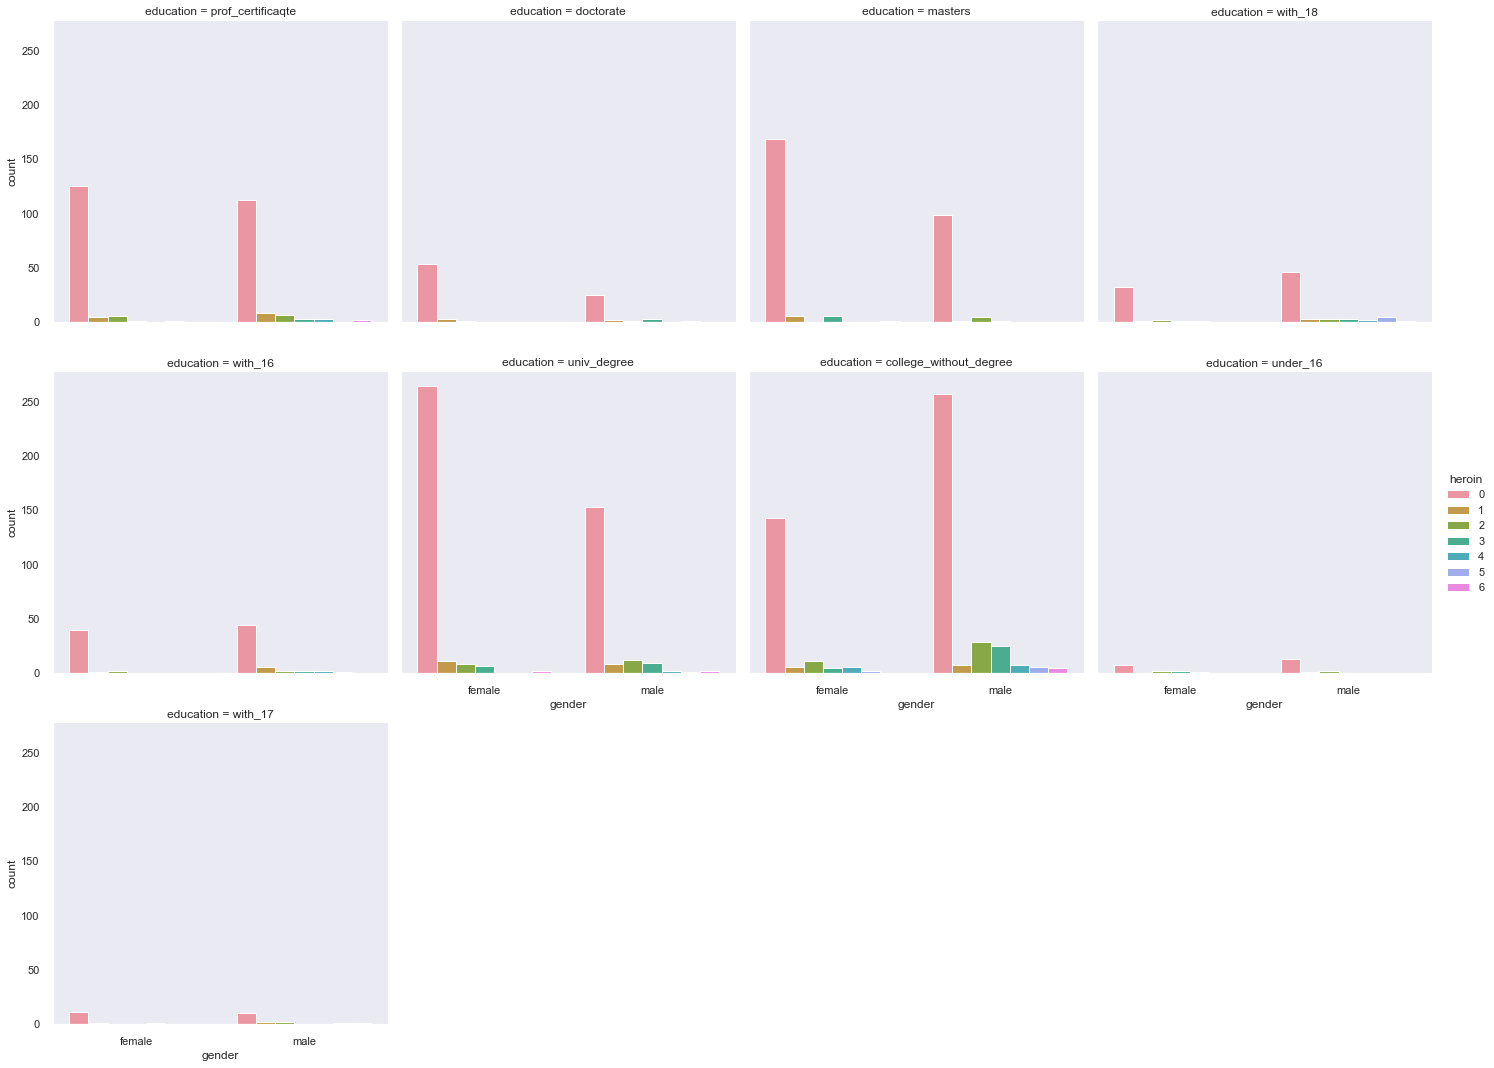

In [20]:
sns.set(style="dark", palette='viridis')
sns.catplot("gender", col='education', data=drugs_vis, hue='heroin', kind="count", col_wrap=4);

Apparently, there are many stoners in college dropouts -- who would have thought! Also, there haven't been too many heroin addicts taking part in the online survey.

Now we want to see **what drugs correlate with each other**, so that we can define certain drug-consumption-clusters after that:

In [21]:
drugs_corr = drugs_vis[['alcohol', 'amphet', 'amyl', 
                     'benzos','caff','cannabis', 'choc', 'coke', 'crack', 
                     'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'shrooms', 'nicotine', 'vsa']].copy()


<AxesSubplot:>

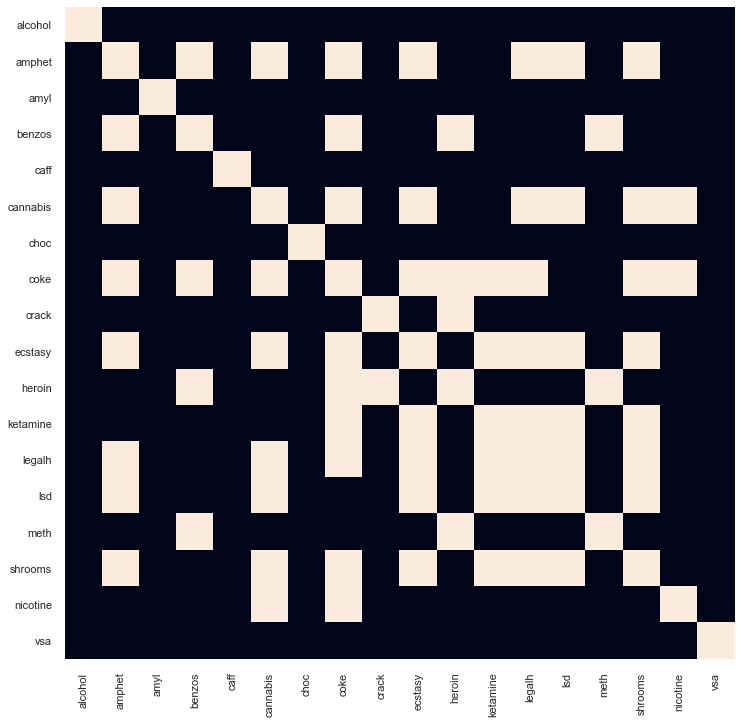

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(drugs_corr.corr()>0.4,cbar=False)


Now let's try to make a class for general illegal substance addiction. We will only target respondents having consumed illegal drugs (and legal highs) yesterday or in the last week. This is certainly not a bulletproof method, but it's the best proxy we can get with the data at hand. Later on, we will also construct a party, a stoner and a junkie cluster with different drugs each!

**Illegal Substance Addiction Cluster**

In [23]:
drugs_general_risk = drugs.copy()

In [24]:
drugs_general_risk = drugs_general_risk.replace(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],[0,0,0,0,0,1,1])

In [25]:
drugs_general_risk['addict']= drugs_general_risk['amphet']+ drugs_general_risk['amyl'] + drugs_general_risk['benzos'] +  drugs_general_risk['cannabis'] + drugs_general_risk['coke'] + drugs_general_risk['crack'] + drugs_general_risk['ecstasy'] + drugs_general_risk['heroin'] + drugs_general_risk['ketamine'] + drugs_general_risk['legalh'] + drugs_general_risk['lsd'] + drugs_general_risk['meth'] + drugs_general_risk['shrooms'] + drugs_general_risk['vsa'] 


In [26]:
drugs_general_risk['addict_binary'] = drugs_general_risk.addict.replace([2,3,4,5,6,7,8,9,10,11],[1,1,1,1,1,1,1,1,1,1])

In [27]:
drugs_general_risk.addict_binary.value_counts()

0    1022
1     855
Name: addict_binary, dtype: int64

In [28]:
general_scores= pd.pivot_table(drugs_general_risk, index = 'addict_binary', values = ['nscore', 'escore','oscore','ascore','cscore', 'impulsive', 'ss' ])
general_scores

ascore    cscore    escore  impulsive    nscore    oscore  \
addict_binary                                                                
0              0.137884  0.240505  0.054379  -0.241297 -0.113155 -0.307689   
1             -0.166259 -0.288346 -0.069285   0.300048  0.134046  0.360710   

                     ss  
addict_binary            
0             -0.351518  
1              0.403915

In [105]:
general_scores_t = general_scores.T
general_scores_t[0]

ascore       0.137884
cscore       0.240505
escore       0.054379
impulsive   -0.241297
nscore      -0.113155
oscore      -0.307689
ss          -0.351518
Name: 0, dtype: float64

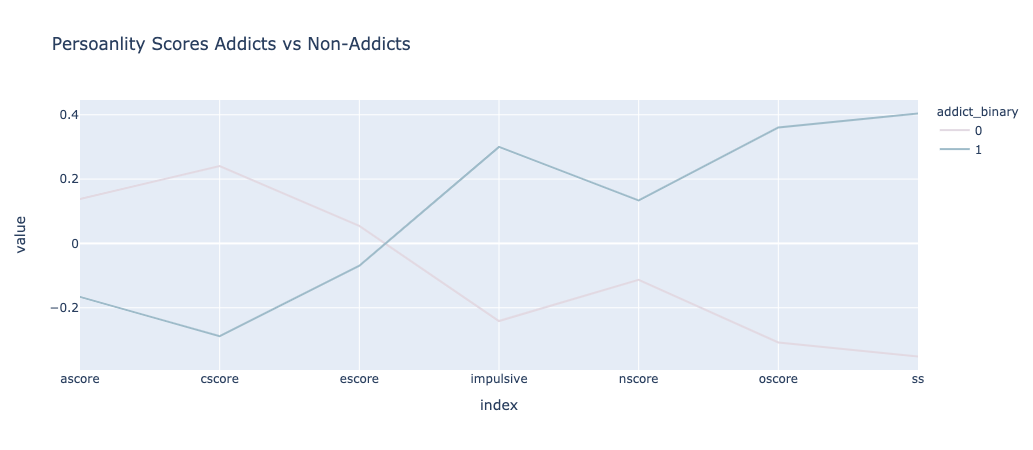

In [117]:
general_line = px.line(data_frame=general_scores_t, title= 'Persoanlity Scores Addicts vs Non-Addicts', color_discrete_sequence=px.colors.cyclical.Twilight,labels={'0': 'Non-Addicts', '1': 'Addicts (potentially)'})
general_line.show()

In [31]:
X_general = drugs_general_risk[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore','escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss']]
y_general= drugs_general_risk['addict_binary']

In [32]:
RSEED=420
X_train, X_test, y_train, y_test = train_test_split(X_general, y_general, test_size=0.3, random_state=RSEED)

That looks pretty good. Let's now define a specific cluster of party drug users via a new dataframe.


**The Party Cluster**

In [33]:
drugs_party = drugs.copy()

In [34]:
drugs_party = drugs_party.replace(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],[0,0,0,0,1,1,1])

In [35]:
drugs_party['party_user'] = drugs_party['ecstasy'] + drugs_party['ketamine'] + drugs_party['amphet'] + drugs_party['coke']

In [36]:
drugs_party.party_user.value_counts()

0    1415
1     277
2     136
3      36
4      13
Name: party_user, dtype: int64

In [37]:
drugs_party['party_user_binary'] = drugs_party.party_user.replace([2,3,4],[1,1,1])

In [38]:
drugs_party.party_user_binary.value_counts()

0    1415
1     462
Name: party_user_binary, dtype: int64

<br/>
This doesn't look too balanced. We will probably get a good accuracy due to the big amount of true negatives, but we're mainly iterested in a high recall score. So let's use a 'synthetic minority oversampling technique' to tackle that problem:

In [39]:
from imblearn.over_sampling import SMOTE

In [40]:
X_party = drugs_party[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore','escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss']]
y_party = drugs_party['party_user_binary']

In [41]:
oversample = SMOTE()

In [42]:
X_train_party, X_test_party, y_train_party, y_test_party = train_test_split(X_party, y_party, test_size=0.3, random_state=RSEED, stratify=y_party)

In [43]:
X_train_party, y_train_party = oversample.fit_resample(X_train_party, y_train_party)

In [44]:
print(X_train_party.shape, y_train_party.shape)

(1980, 12) (1980,)


In [45]:
y_train_party.value_counts()

1    990
0    990
Name: party_user_binary, dtype: int64

<br/>
Now that looks better. Let's build two more custom clusters for Stoner- and for Junkie-Drugs. It will be cool to see if our data  on socio-demographic background and personality enables us to classify these specific classes.


<br/>

**The Stoner Cluster**

In [46]:
drugs_stoner = drugs.copy()

In [47]:
drugs_stoner = drugs_stoner.replace(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],[0,0,0,0,0,1,1])

In [48]:
drugs_stoner['stoner'] = drugs_stoner['cannabis'] + drugs_stoner['shrooms'] + drugs_stoner['lsd']

In [49]:
drugs_stoner.stoner.value_counts()

0    1207
1     594
2      70
3       6
Name: stoner, dtype: int64

In [50]:
drugs_stoner['stoner_binary'] = drugs_stoner.stoner.replace([2,3],[1,1])

In [51]:
drugs_stoner.stoner_binary.value_counts()

0    1207
1     670
Name: stoner_binary, dtype: int64

In [52]:
X_stoner = drugs_stoner[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore','escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss']]
y_stoner = drugs_stoner['stoner_binary']

In [53]:
X_train_stoner, X_test_stoner, y_train_stoner, y_test_stoner = train_test_split(X_stoner, y_stoner, test_size=0.3, random_state=RSEED, stratify =y_stoner)

In [54]:
X_train_stoner, y_train_stoner = oversample.fit_resample(X_train_stoner, y_train_stoner)

In [55]:
print(X_train_stoner.shape, y_train_stoner.shape)



(1688, 12) (1688,)


<br/>

**The Junkie Cluster**

In [56]:
drugs_junkies = drugs.copy()

In [57]:
drugs_junkies = drugs_junkies.replace(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],[0,0,0,0,0,1,1])

In [58]:
drugs_junkies['junkie'] = drugs_junkies['heroin'] + drugs_junkies['meth'] + drugs_junkies['crack'] + drugs_junkies['benzos']

In [59]:
drugs_junkies.junkie.value_counts()

0    1618
1     189
2      61
3       7
4       2
Name: junkie, dtype: int64

In [60]:
drugs_junkies['junkie_binary'] = drugs_junkies.junkie.replace([2,3,4],[1,1,1])

In [61]:
drugs_junkies.junkie_binary.value_counts()

0    1618
1     259
Name: junkie_binary, dtype: int64

In [62]:
X_junkies = drugs_junkies[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore','escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss']]
y_junkies = drugs_junkies['junkie_binary']

In [63]:
X_train_junkies, X_test_junkies, y_train_junkies, y_test_junkies = train_test_split(X_junkies, y_junkies, test_size=0.3, random_state=RSEED, stratify = y_junkies )

In [64]:
X_train_junkies, y_train_junkies = oversample.fit_resample(X_train_junkies, y_train_junkies)

In [65]:
print(X_train_junkies.shape, y_train_junkies.shape)

(2264, 12) (2264,)


<br/>

# Classification Algorithms

Now we want to explore the efficacy of different classification models. Since it is our goal to estimate wether someone's personality and socio-demographic background exhibit the potential for a drug addiction (so that proper interventions can be carried out in the right places), the metric we aim at improving will be the model's recall. We start with model building for general drug addiction.

In [66]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy.stats import uniform
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 


from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score 
from sklearn.model_selection import cross_val_predict

At first, we want to build a function for testing **default classifiers**:

In [67]:
gnb = GaussianNB()
dtc = DecisionTreeClassifier()
logreg = LogisticRegression()
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier()
abc = AdaBoostClassifier()

classifiers = [gnb,dtc, logreg,
                knn, rfc,xgb,abc]




In [68]:
def cross_val(c, X, y):
    
    g=[]
    h=[]
    for classifier in classifiers:
        y_pred = cross_val_predict(classifier, X_train, y_train, cv=5)
        recall = sk.metrics.recall_score(y_train, y_pred, average = 'macro')
        g.append(recall)
        h.append(classifier)
        
    res=list(zip(g, h))
    res.sort(key=lambda tup: tup[0], reverse=True)
    return res

<br/>

**Classifying Risk of Addiction in General**

In [69]:
cross_val(classifiers, X_train, y_train)

[(0.7904790654573025, LogisticRegression()),
 (0.7892575327848137, XGBClassifier()),
 (0.7886912283657671, GaussianNB()),
 (0.7880044087501052, RandomForestClassifier()),
 (0.7685464697237745, AdaBoostClassifier()),
 (0.7643834302135109, KNeighborsClassifier()),
 (0.6952509992230864, DecisionTreeClassifier())]

In [76]:
best_simple = cross_val(classifiers, X_train, y_train)[0]
best_simple

(0.7913601134480919, RandomForestClassifier())

Now we have a promising model that we can tune. First, we will carry out a **randomized search cross validation** in order to pin down orders of magnitude for the **following full fledged grid search**. 

In [77]:
param_grid_rand = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 15],
    'bootstrap': [True, False]
}

In [78]:
randomized_search_general = RandomizedSearchCV(best_simple[1], param_grid_rand, n_jobs = -1, 
                        scoring = 'recall', cv = 5, random_state=RSEED, verbose=1)


In [79]:
randomized_search_general.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 

In [80]:
randomized_search_general.best_params_

{'n_estimators': 13,
 'min_samples_split': 5,
 'max_leaf_nodes': 41,
 'max_features': 0.5,
 'max_depth': 10,
 'bootstrap': True}

In [81]:
param_grid_rfc = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 9, 18],
    'n_estimators': [20, 40, 60],
    'max_leaf_nodes': [10,20,30],
    'bootstrap': [True, False]
}

In [82]:
grid_search_general = GridSearchCV(best_simple[1], param_grid_rfc, scoring = 'recall', verbose= 1, n_jobs=-1)


In [83]:
grid_search_general.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4853 out of 4860 | elapsed:  2.2min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed:  2.2min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'max_features': [2, 3], 'max_leaf_nodes': [10, 20, 30],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 9, 18],
                         'n_estimators': [20, 40, 60]},
             scoring='recall', verbose=1)

In [84]:
grid_search_general.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 3,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 40}

In [85]:
y_train_pred_best_general = grid_search_general.predict(X_train)
 
print(classification_report(y_train, y_train_pred_best_general))
print(confusion_matrix(y_train, y_train_pred_best_general))                                   

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       717
           1       0.83      0.85      0.84       596

    accuracy                           0.85      1313
   macro avg       0.85      0.85      0.85      1313
weighted avg       0.85      0.85      0.85      1313

[[610 107]
 [ 91 505]]


This looks promising. Later on, we will run this model on the test data. For now, **we repeat the same procedure for the other clusters**.

<br/>

Let's  begin with the **party drugs**!

In [86]:
cross_val(classifiers, X_train_party, y_train_party)

[(0.7951300160062902, RandomForestClassifier()),
 (0.7904790654573025, LogisticRegression()),
 (0.7892575327848137, XGBClassifier()),
 (0.7886912283657671, GaussianNB()),
 (0.7685464697237745, AdaBoostClassifier()),
 (0.7643834302135109, KNeighborsClassifier()),
 (0.6990103713272117, DecisionTreeClassifier())]

In [89]:
best_party = cross_val(classifiers, X_train_party, y_train_party)[0]
best_party[1]

RandomForestClassifier()

In [91]:
randomized_search_party= RandomizedSearchCV(best_party[1], param_grid_rand, n_jobs = -1, 
                        scoring = 'recall', cv = 5, random_state=RSEED, verbose=1)


In [92]:
randomized_search_party.fit(X_train_party,y_train_party )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.8s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 

In [93]:
randomized_search_party.best_params_

{'n_estimators': 130,
 'min_samples_split': 15,
 'max_leaf_nodes': 37,
 'max_features': None,
 'max_depth': 4,
 'bootstrap': True}

In [94]:
param_grid_rfc_party = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 9, 18],
    'n_estimators': [30, 60, 120],
    'max_leaf_nodes': [10,20,30],
    'bootstrap': [True, False]
}

In [95]:
grid_search_party = GridSearchCV(best_party[1], param_grid_rfc_party, scoring = 'recall', verbose= 1, n_jobs=-1)
grid_search_party.fit(X_train_party, y_train_party)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4574 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed:  4.9min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 15, 20],
                         'max_features': [2, 3], 'max_leaf_nodes': [10, 20, 30],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 9, 18],
                         'n_estimators': [30, 60, 120]},
             scoring='recall', verbose=1)

In [96]:
grid_search_party.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 3,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 4,
 'min_samples_split': 18,
 'n_estimators': 60}

In [97]:
y_train_pred_best_party = grid_search_party.predict(X_train_party)
print(classification_report(y_train_party, y_train_pred_best_party))
print(confusion_matrix(y_train_party, y_train_pred_best_party)) 

              precision    recall  f1-score   support

           0       0.90      0.81      0.86       990
           1       0.83      0.91      0.87       990

    accuracy                           0.86      1980
   macro avg       0.87      0.86      0.86      1980
weighted avg       0.87      0.86      0.86      1980

[[805 185]
 [ 88 902]]


<br/>
<br/>

Now let's find a good classifier for our **stoner** friends!

In [98]:
best_stoner = cross_val(classifiers, X_train_stoner, y_train_stoner)[0]
best_stoner[1]

RandomForestClassifier()

In [99]:
randomized_search_stoner= RandomizedSearchCV(best_stoner[1], param_grid_rand, n_jobs = -1, 
                        scoring = 'recall', cv = 5, random_state=RSEED, verbose=1)


In [100]:
randomized_search_stoner.fit(X_train_stoner,y_train_stoner )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 

In [118]:
randomized_search_stoner.best_params_

{'n_estimators': 145,
 'min_samples_split': 5,
 'max_leaf_nodes': 15,
 'max_features': 0.7,
 'max_depth': 6,
 'bootstrap': False}

In [119]:
param_grid_rfc_stoner = {
    'bootstrap': [True],
    'max_depth': [3, 5, 10],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 9, 18],
    'n_estimators': [30, 60, 120],
    'max_leaf_nodes': [10,20,30],
    'bootstrap': [True, False]
}

In [120]:
grid_search_stoner = GridSearchCV(best_stoner[1], param_grid_rfc_stoner, scoring = 'recall', verbose= 1, n_jobs=-1)
grid_search_stoner.fit(X_train_party, y_train_party)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed:  4.3min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [3, 5, 10],
                         'max_features': [2, 3], 'max_leaf_nodes': [10, 20, 30],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 9, 18],
                         'n_estimators': [30, 60, 120]},
             scoring='recall', verbose=1)

In [121]:
grid_search_stoner.best_params_

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 3,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 30}

In [122]:
y_train_pred_best_stoner = grid_search_party.predict(X_train_stoner)
print(classification_report(y_train_stoner, y_train_pred_best_stoner))
print(confusion_matrix(y_train_stoner, y_train_pred_best_stoner)) 

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       844
           1       0.82      0.76      0.79       844

    accuracy                           0.80      1688
   macro avg       0.80      0.80      0.80      1688
weighted avg       0.80      0.80      0.80      1688

[[706 138]
 [199 645]]


<br/>

And now for our **proper junkie** cluster:

In [123]:
best_junkie = cross_val(classifiers, X_train_junkies, y_train_junkies)[0]
best_junkie[1]

RandomForestClassifier()

In [125]:
randomized_search_junkie= RandomizedSearchCV(best_junkie[1], param_grid_rand, n_jobs = -1, 
                        scoring = 'recall', cv = 5, random_state=RSEED, verbose=1)


In [126]:
randomized_search_junkie.fit(X_train_junkies ,y_train_junkies )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    5.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.1s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 

In [127]:
randomized_search_junkie.best_params_

{'n_estimators': 13,
 'min_samples_split': 5,
 'max_leaf_nodes': 41,
 'max_features': 0.5,
 'max_depth': 10,
 'bootstrap': True}

In [128]:
param_grid_rfc_junkie = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 9, 18],
    'n_estimators': [30, 60, 120],
    'max_leaf_nodes': [10,20,30],
    'bootstrap': [True, False]
}

In [129]:
grid_search_junkie = GridSearchCV(best_junkie[1], param_grid_rfc_junkie, scoring = 'recall', verbose= 1, n_jobs=-1)
grid_search_junkie.fit(X_train_junkies, y_train_junkies)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 742 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1092 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1542 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2092 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2742 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3492 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4342 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed:  5.8min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 15, 20],
                         'max_features': [2, 3], 'max_leaf_nodes': [10, 20, 30],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 9, 18],
                         'n_estimators': [30, 60, 120]},
             scoring='recall', verbose=1)

In [130]:
grid_search_junkie.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 2,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 60}

In [131]:
y_train_pred_best_junkie = grid_search_junkie.predict(X_train_junkies)
print(classification_report(y_train_junkies, y_train_pred_best_junkie))
print(confusion_matrix(y_train_junkies, y_train_pred_best_junkie)) 

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1132
           1       0.89      0.93      0.91      1132

    accuracy                           0.90      2264
   macro avg       0.90      0.90      0.90      2264
weighted avg       0.90      0.90      0.90      2264

[[ 996  136]
 [  83 1049]]


# Testing 
Ladies and Gentlemen, we're about to see how our champions perform on the test data -- but before each test, let's build some naive bayes models as baselines!


In [136]:
base_general = gnb.fit(X_train, y_train)

In [138]:
y_base_general = base_general.predict(X_test)
print(classification_report(y_test, y_base_general))
print(confusion_matrix(y_test, y_base_general))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       305
           1       0.77      0.81      0.79       259

    accuracy                           0.80       564
   macro avg       0.80      0.80      0.80       564
weighted avg       0.80      0.80      0.80       564

[[241  64]
 [ 49 210]]


In [132]:
y_test_pred_general = grid_search_general.predict(X_test)
print(classification_report(y_test, y_test_pred_general))
print(confusion_matrix(y_test, y_test_pred_general))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       305
           1       0.78      0.80      0.79       259

    accuracy                           0.80       564
   macro avg       0.80      0.80      0.80       564
weighted avg       0.80      0.80      0.80       564

[[245  60]
 [ 52 207]]


So for our system in general, we will be able to find **80% of the onsets of drug careers** -- that's something we can work with! The plain naive bayes is very strong when it comes to the test data though. In the future, we should check more thoroughly which model we can improve on.

Now for specific drug cultures:



In [139]:
base_party = gnb.fit(X_train_party, y_train_party)

In [141]:
y_base_party = base_party.predict(X_test)
print(classification_report(y_test_party, y_base_party))
print(confusion_matrix(y_test_party, y_base_party))

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       425
           1       0.25      0.42      0.32       139

    accuracy                           0.55       564
   macro avg       0.50      0.51      0.49       564
weighted avg       0.63      0.55      0.58       564

[[250 175]
 [ 80  59]]


In [133]:
y_test_pred_party = grid_search_party.predict(X_test_party)
print(classification_report(y_test_party, y_test_pred_party))
print(confusion_matrix(y_test_party, y_test_pred_party))

              precision    recall  f1-score   support

           0       0.87      0.75      0.80       425
           1       0.46      0.66      0.54       139

    accuracy                           0.73       564
   macro avg       0.67      0.70      0.67       564
weighted avg       0.77      0.73      0.74       564

[[317 108]
 [ 47  92]]


This looks okayish. At least, our model is much better than a plain naive bayes. The **original under-representation of drug users** is probably still a problem for the generalization of our classifiers. So one learning will be that we **certainly need much more data concernig drug usage and personality types**.

How does it look for the stoners then?

In [142]:
base_stoner = gnb.fit(X_train_stoner, y_train_stoner)

In [143]:
y_base_stoner = base_party.predict(X_test_stoner)
print(classification_report(y_test_stoner, y_base_stoner))
print(confusion_matrix(y_test_stoner, y_base_stoner))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       363
           1       0.63      0.71      0.67       201

    accuracy                           0.75       564
   macro avg       0.73      0.74      0.73       564
weighted avg       0.76      0.75      0.75       564

[[280  83]
 [ 58 143]]


In [144]:
y_test_pred_stoner = grid_search_stoner.predict(X_test_stoner)
print(classification_report(y_test_stoner, y_test_pred_stoner))
print(confusion_matrix(y_test_stoner, y_test_pred_stoner))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       363
           1       0.67      0.64      0.65       201

    accuracy                           0.76       564
   macro avg       0.74      0.73      0.73       564
weighted avg       0.76      0.76      0.76       564

[[300  63]
 [ 73 128]]


128 out of 201 stoners is also okay, but certainly not the best thing in the world. Our tuned random forest fares quite a bit worse than the naive baseline. The same problem of original underrepresentation probably limits generalization here too.

In [145]:
base_junkies = gnb.fit(X_train_junkies, y_train_junkies)

In [147]:
y_test_base_junkies = base_junkies.predict(X_test_junkies)
print(classification_report(y_test_junkies, y_test_base_junkies))
print(confusion_matrix(y_test_junkies, y_test_base_junkies))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82       486
           1       0.27      0.63      0.38        78

    accuracy                           0.72       564
   macro avg       0.60      0.68      0.60       564
weighted avg       0.83      0.72      0.76       564

[[355 131]
 [ 29  49]]


In [135]:
rfc_junkies = rfc.fit(X_train_junkies, y_train_junkies)
y_test_pred_junkies = rfc_junkies.predict(X_test_junkies)
print(classification_report(y_test_junkies, y_test_pred_junkies))
print(confusion_matrix(y_test_junkies, y_test_pred_junkies))


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       486
           1       0.35      0.21      0.26        78

    accuracy                           0.84       564
   macro avg       0.61      0.57      0.58       564
weighted avg       0.81      0.84      0.82       564

[[456  30]
 [ 62  16]]


Here, our baseline model is much better than the tuned random forest, which was certainly overfitted to the few original training observations. In general, **we have to learn much more original cases of heavy substance addiction**!